# SafeNSound: Initial MFCC Development

## 1. Importing Libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa as lb
import librosa.display as ld
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import sounddevice as sd
from sklearn.model_selection import train_test_split

## 2. Datasets

In [ ]:
PATH = "datasets/"
EMERGENCY_PATH = os.path.join(PATH, "emergency/")
NORMAL_PATH = os.path.join(PATH, "non-emergency/")

def load_audio_files(directory, filename):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory {directory} does not exist.")

    if filename.endswith('.wav'):
        file_path = os.path.join(directory, filename)
        try:
            wav, sr = lb.load(file_path, sr=16000, mono=True)
            ##wav = tf.convert_to_tensor(wav, dtype=tf.float32)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return wav, sr

#get audio real-time
## def record_audio(duration=5, sample_rate=16000):


## 3. Extract MFCC

In [25]:
def extract_mfcc(audio, sample_rate, n_mfcc=40, hop_length=512, max_len=160):
    mfcc = lb.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc, hop_length=hop_length)
    
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0,0),(0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    
    mfcc = mfcc[..., np.newaxis]
    
    return mfcc

## 4. Build Dataset

In [26]:
X = []
y = []
labels = {"emergency": 1, "non-emergency": 0}

emergency_labels = {"crying sound", "door noise", "glassbreak sounds", "gunshots", "screaming sound"}
non_emergency_labels = {"clap", "door sound", "fireworks", "object noise", "toilet noise"}

emergency_count = 0;
non_emergency_count = 0;

for label, idx in labels.items():
    main_path = EMERGENCY_PATH if label == "emergency" else NORMAL_PATH
    subfolders =  emergency_labels if label == "emergency" else non_emergency_labels
            
    for subfolder in subfolders:
        folder = os.path.join(main_path, subfolder)

        if not os.path.exists(folder):
            print(f"Warning: Directory {folder} does not exist. Skipping...")
            continue

        for file in os.listdir(folder):
            if file.endswith(".wav"):
                try:
                    wav, sr = load_audio_files(folder, file)
                    mfcc = extract_mfcc(wav, sr)

                    # try:
                    #     plt.figure(figsize=(12, 5))
                    #     lb.display.specshow(mfcc, x_axis='time', sr=sr)
                    #     plt.colorbar()
                    #     plt.title(file)
                    #     plt.tight_layout()
                    #     plt.show()
                    # except Exception as e:
                    #     print(f"Error displaying MFCC for {file}: {e}")
                    #     continue

                    X.append(mfcc)
                    y.append(idx)

                    if label == "emergency":
                        emergency_count += 1   
                    else:
                        non_emergency_count += 1

                except Exception as e:
                    print(f"Error processing {file} in {folder}: {e}")
                    continue

X = np.array(X)
y = np.array(y)

y = to_categorical(y, num_classes=2)

print(f"Emergency samples: {emergency_count}")
print(f"Non-emergency samples: {non_emergency_count}")
print(f"Total samples: {len(X)}")
print(f"Data shape: {X.shape}")

print(f"Class distribution: {np.sum(y, axis=0)}")

Emergency samples: 23
Non-emergency samples: 13
Total samples: 36
Data shape: (36, 40, 160, 1)
Class distribution: [13. 23.]


## 5. Split data

In [27]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

## 6. CNN

In [32]:
def build_cnn(input_shape, num_classes=2):

    model = models.Sequential([
        #first conv layer  
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        #second conv layer
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # #third conv layer
        # layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        # layers.MaxPooling2D((2,2)),
        # layers.Dropout(0.3),

        #dense
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [33]:
input_shape = (X.shape[1], X.shape[2], X.shape[3])

model = build_cnn(input_shape, num_classes=2)

## 7. Train

In [34]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6000 - loss: 1.6317 - val_accuracy: 0.8000 - val_loss: 0.5045
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8000 - loss: 0.5701 - val_accuracy: 0.4000 - val_loss: 3.8443
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6800 - loss: 2.1580 - val_accuracy: 1.0000 - val_loss: 0.0662
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8400 - loss: 1.3150 - val_accuracy: 1.0000 - val_loss: 1.2159e-05
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7600 - loss: 2.0090 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8800 - loss: 1.3486 - val_accuracy: 1.0000 - val_loss: 3.4226e-04
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9600 - loss: 0.4268 - val_accuracy: 1.0000 - val_loss: 4.0069e-04
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9200 - loss: 0.2940 - val_accuracy: 1.0000 - 

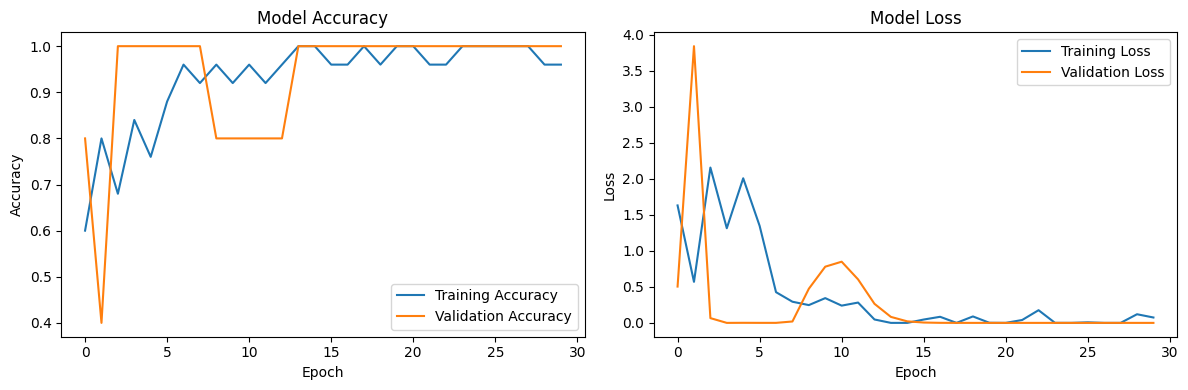

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6667 - loss: 2.2018
Test accuracy: 0.6666666865348816


In [35]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)